# Delhivery Case Study —  

**Objective:** Build a cleaned, trip-level dataset (one row per `trip_uuid`) from the raw Delhivery pipeline rows, perform EDA, run hypothesis tests comparing `actual_*` vs `osrm_*` fields, engineer features, handle outliers, and produce business insights and actionable recommendations.


##1 - Data Reading and Exploration

In [206]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [207]:
df = pd.read_csv('delhivery_data.csv')
print("Data shape: ", df.shape)
display(df.head())

Data shape:  (144867, 24)


,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [208]:
# Quick diagnostics
print('\n--- dtypes ---')
print(df.dtypes)
print('\n---missing values (top 20) ---')
print(df.isna().sum().sort_values(ascending = False).head(20))
print('\n--- basic description(numerical) ---')
display(df.describe(include='number').T)
print('\n--- basic description(object)---')
display(df.describe(include='object').T)


--- dtypes ---
data                               object
trip_creation_time                 object
route_schedule_uuid                object
route_type                         object
trip_uuid                          object
source_center                      object
source_name                        object
destination_center                 object
destination_name                   object
od_start_time                      object
od_end_time                        object
start_scan_to_end_scan            float64
is_cutoff                            bool
cutoff_factor                       int64
cutoff_timestamp                   object
actual_distance_to_destination    float64
actual_time                       float64
osrm_time                         float64
osrm_distance                     float64
factor                            float64
segment_actual_time               float64
segment_osrm_time                 float64
segment_osrm_distance             float64
segment_factor    

,count,mean,std,min,25%,50%,75%,max
start_scan_to_end_scan,144867.0,961.262986,1037.012769,20.000000,161.000000,449.000000,1634.000000,7898.000000
cutoff_factor,144867.0,232.926567,344.755577,9.000000,22.000000,66.000000,286.000000,1927.000000
actual_distance_to_destination,144867.0,234.073372,344.990009,9.000045,23.355874,66.126571,286.708875,1927.447705
actual_time,144867.0,416.927527,598.103621,9.000000,51.000000,132.000000,513.000000,4532.000000
osrm_time,144867.0,213.868272,308.011085,6.000000,27.000000,64.000000,257.000000,1686.000000
osrm_distance,144867.0,284.771297,421.119294,9.008200,29.914700,78.525800,343.193250,2326.199100
factor,144867.0,2.120107,1.715421,0.144000,1.604264,1.857143,2.213483,77.387097
segment_actual_time,144867.0,36.196111,53.571158,-244.000000,20.000000,29.000000,40.000000,3051.000000
segment_osrm_time,144867.0,18.507548,14.775960,0.000000,11.000000,17.000000,22.000000,1611.000000
segment_osrm_distance,144867.0,22.829020,17.860660,0.000000,12.070100,23.513000,27.813250,2191.403700



--- basic description(object)---


,count,unique,top,freq
data,144867,2,training,104858
trip_creation_time,144867,14817,2018-09-22 04:55:04.835022,101
route_schedule_uuid,144867,1504,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,1812
route_type,144867,2,FTL,99660
trip_uuid,144867,14817,trip-153759210483476123,101
source_center,144867,1508,IND000000ACB,23347
source_name,144574,1498,Gurgaon_Bilaspur_HB (Haryana),23347
destination_center,144867,1481,IND000000ACB,15192
destination_name,144606,1468,Gurgaon_Bilaspur_HB (Haryana),15192
od_start_time,144867,26369,2018-09-21 18:37:09.322207,81


##2 - Data cleaning and parsing

In [209]:
#Basic Cleaning
df = df.dropna(how="any")
df = df.reset_index(drop=True)

In [210]:
df["od_start_time"] = pd.to_datetime(df["od_start_time"])
df["od_end_time"] = pd.to_datetime(df["od_end_time"])

##3 - Feature engineering

In [211]:
# Create Segment Key
df["segment_key"] = (df['trip_uuid']+df["source_center"]+df["destination_center"])
segment_cols = ["segment_actual_time",'segment_osrm_distance','segment_osrm_time']

for col in segment_cols:
  df[col + "_sum"] = df.groupby("segment_key")[col].cumsum()

df[[col+ "_sum" for col in segment_cols]]

,segment_actual_time_sum,segment_osrm_distance_sum,segment_osrm_time_sum
0,14.0,11.9653,11.0
1,24.0,21.7243,20.0
2,40.0,32.5395,27.0
3,61.0,45.5619,39.0
4,67.0,49.4772,44.0
...,...,...,...
144311,92.0,65.3487,94.0
144312,118.0,82.7212,115.0
144313,138.0,103.4265,149.0
144314,155.0,122.3150,176.0


In [212]:
# Segment Aggregation Dictionary
create_segment_dict = {
    "data": "first",
    "trip_creation_time": "first",
    "route_schedule_uuid": "first",
    "route_type": "first",
    "trip_uuid":"first",

   	'source_center'	: 'first',
    'source_name'	: 'first',
    'destination_center': 'last',
    'destination_name'	: 'last',

    'od_start_time'	:'first',
    'od_end_time':'first',
    'start_scan_to_end_scan':'first',

    'actual_distance_to_destination':'last',
    'actual_time'	:'last',

    'osrm_time'	:'last',
    'osrm_distance'		:'last',

    'segment_actual_time_sum'	:'last',
    'segment_osrm_time_sum'	:'last',
    'segment_osrm_distance_sum':'last',
}

In [213]:
# Create Segment-Level Dataset
segment = (df.groupby("segment_key").agg(create_segment_dict).reset_index())
segment = (segment.sort_values(by=["segment_key","od_end_time"], ascending=True).reset_index(drop=True))

In [214]:
# OD Time Difference (Hours)
segment["od_time_diff_hour"] = ((segment["od_end_time"] - segment["od_start_time"]).dt.total_seconds()/3600)
segment["od_time_diff_hour"]

,od_time_diff_hour
0,21.010074
1,16.658423
2,0.980540
3,2.046325
4,13.910649
...,...
26217,1.035253
26218,1.518130
26219,0.736240
26220,4.791233


In [215]:
# Trip-Level Aggregation Dictionary
create_trip_dict = {
    "data": "first",
    "trip_creation_time": "first",
    "route_schedule_uuid": "first",
    "route_type": "first",
    "trip_uuid":"first",

   	'source_center'	: 'first',
    'source_name'	: 'first',
    'destination_center': 'last',
    'destination_name'	: 'last',

    'start_scan_to_end_scan':'first',
    'od_time_diff_hour':'sum',

    'actual_distance_to_destination':'sum',
    'actual_time'	:'sum',

    'osrm_time'	:'sum',
    'osrm_distance'		:'sum',

    'segment_actual_time_sum'	:'sum',
    'segment_osrm_time_sum'	:'sum',
    'segment_osrm_distance_sum':'sum',
}

In [216]:
trip = (segment.groupby('trip_uuid').agg(create_trip_dict).reset_index(drop=True)).sort_values(by=["trip_uuid"])

In [217]:
display(trip.head())


,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,od_time_diff_hour,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,segment_actual_time_sum,segment_osrm_time_sum,segment_osrm_distance_sum
0,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,trip-153671041653548748,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),1260.0,37.668497,824.732854,1562.0,717.0,991.3523,1548.0,1008.0,1320.4733
1,training,2018-09-12 00:00:22.886430,thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...,Carting,trip-153671042288605164,IND561203AAB,Doddablpur_ChikaDPP_D (Karnataka),IND561203AAB,Doddablpur_ChikaDPP_D (Karnataka),58.0,3.026865,73.186911,143.0,68.0,85.1110,141.0,65.0,84.1894
2,training,2018-09-12 00:00:33.691250,thanos::sroute:de5e208e-7641-45e6-8100-4d9fb1e...,FTL,trip-153671043369099517,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),834.0,65.572709,1927.404273,3347.0,1740.0,2354.0665,3308.0,1941.0,2545.2678
3,training,2018-09-12 00:01:00.113710,thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...,Carting,trip-153671046011330457,IND400072AAB,Mumbai Hub (Maharashtra),IND401104AAA,Mumbai_MiraRd_IP (Maharashtra),100.0,1.674916,17.175274,59.0,15.0,19.6800,59.0,16.0,19.8766
4,training,2018-09-12 00:02:09.740725,thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...,FTL,trip-153671052974046625,IND583101AAA,Bellary_Dc (Karnataka),IND583119AAA,Sandur_WrdN1DPP_D (Karnataka),152.0,11.972484,127.448500,341.0,117.0,146.7918,340.0,115.0,146.7919


In [218]:
#Encode Route Type
print(trip["route_type"].value_counts())
trip["route_type"] = trip["route_type"].map({"FTL":0,"Carting":1})

route_type
Carting    8906
FTL        5881
Name: count, dtype: int64


In [219]:
#IQR-Based Outlier Detection
num_cols = trip.select_dtypes(include=["int64","float64"]).columns

Q1 = trip[num_cols].quantile(0.25)
Q3 = trip[num_cols].quantile(0.75)

IQR = Q3 - Q1

trip = trip[~ (
    (trip[num_cols] < (Q1 - 1.5*IQR)) |
    (trip[num_cols] > (Q3 + 1.5*IQR))
).any(axis=1)
]

trip = trip.reset_index(drop = True)

In [220]:
#   Source/Destination parsing helpers

def parse_location(name: str):
    """Parse location name into city, code, type, state.
    Expected format: 'City_Code_Type (State)' or variations."""

    text = str(name)

    # Find matching parentheses properly
    open_idx = text.find('(')
    close_idx = text.rfind(')')  # Use rfind to find the last closing parenthesis

    if open_idx != -1 and close_idx != -1 and close_idx > open_idx:
        main = text[:open_idx].strip()
        state = text[open_idx+1:close_idx].strip()
    else:
        main = text
        state = None

    # Split main part by underscores
    main_parts = main.split('_')

    # Assign parts based on how many we have
    if len(main_parts) >= 3:
        city = main_parts[0]
        code = main_parts[1]
        loc_type = '_'.join(main_parts[2:])  # Join all remaining parts
    elif len(main_parts) == 2:
        city = main_parts[0]
        code = main_parts[1]
        loc_type = None
    elif len(main_parts) == 1:
        city = main_parts[0]
        code = None
        loc_type = None
    else:
        city = code = loc_type = None

    return [city, code, loc_type, state]

# Apply to source and destination columns
trip[["source_city", "source_code", "source_type", "source_state"]] = trip["source_name"].apply(parse_location).apply(pd.Series)
trip[["dest_city", "dest_code", "dest_type", "dest_state"]] = trip["destination_name"].apply(parse_location).apply(pd.Series)

# Show the results
trip[["source_name", "source_city", "source_code", "source_state","destination_name", "dest_city", "dest_code", "dest_state"]].head()

,source_name,source_city,source_code,source_state,destination_name,dest_city,dest_code,dest_state
0,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur,ChikaDPP,Karnataka,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur,ChikaDPP,Karnataka
1,Mumbai Hub (Maharashtra),Mumbai Hub,None,Maharashtra,Mumbai_MiraRd_IP (Maharashtra),Mumbai,MiraRd,Maharashtra
2,Bellary_Dc (Karnataka),Bellary,Dc,Karnataka,Sandur_WrdN1DPP_D (Karnataka),Sandur,WrdN1DPP,Karnataka
3,Chennai_Poonamallee (Tamil Nadu),Chennai,Poonamallee,Tamil Nadu,Chennai_Poonamallee (Tamil Nadu),Chennai,Poonamallee,Tamil Nadu
4,Chennai_Chrompet_DPC (Tamil Nadu),Chennai,Chrompet,Tamil Nadu,Chennai_Vandalur_Dc (Tamil Nadu),Chennai,Vandalur,Tamil Nadu


In [221]:
trip.drop(['source_name', 'destination_name'], axis=1, inplace=True)

In [222]:
trip.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,destination_center,start_scan_to_end_scan,od_time_diff_hour,actual_distance_to_destination,...,segment_osrm_time_sum,segment_osrm_distance_sum,source_city,source_code,source_type,source_state,dest_city,dest_code,dest_type,dest_state
0,training,2018-09-12 00:00:22.886430,thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...,1,trip-153671042288605164,IND561203AAB,IND561203AAB,58.0,3.026865,73.186911,...,65.0,84.1894,Doddablpur,ChikaDPP,D,Karnataka,Doddablpur,ChikaDPP,D,Karnataka
1,training,2018-09-12 00:01:00.113710,thanos::sroute:f0176492-a679-4597-8332-bbd1c7f...,1,trip-153671046011330457,IND400072AAB,IND401104AAA,100.0,1.674916,17.175274,...,16.0,19.8766,Mumbai Hub,None,None,Maharashtra,Mumbai,MiraRd,IP,Maharashtra
2,training,2018-09-12 00:02:09.740725,thanos::sroute:d9f07b12-65e0-4f3b-bec8-df06134...,0,trip-153671052974046625,IND583101AAA,IND583119AAA,152.0,11.972484,127.448500,...,115.0,146.7919,Bellary,Dc,None,Karnataka,Sandur,WrdN1DPP,D,Karnataka
3,training,2018-09-12 00:02:34.161600,thanos::sroute:9bf03170-d0a2-4a3f-aa4d-9aaab3d...,1,trip-153671055416136166,IND600056AAA,IND600056AAA,60.0,3.174797,24.597048,...,23.0,28.0647,Chennai,Poonamallee,None,Tamil Nadu,Chennai,Poonamallee,None,Tamil Nadu
4,training,2018-09-12 00:04:22.011653,thanos::sroute:a97698cc-846e-41a7-916b-88b1741...,1,trip-153671066201138152,IND600044AAD,IND600048AAA,98.0,1.633427,9.100510,...,13.0,12.0184,Chennai,Chrompet,DPC,Tamil Nadu,Chennai,Vandalur,Dc,Tamil Nadu


In [223]:
trip = trip.copy()

# Standardize units  -- We standardize units so comparisons are meaningful.
trip["od_time_min"] = trip["od_time_diff_hour"] * 60
trip["scan_time_min"] = trip["start_scan_to_end_scan"]


##4 - Exploratory Data Analysis

###4.1 - Visual Analysis

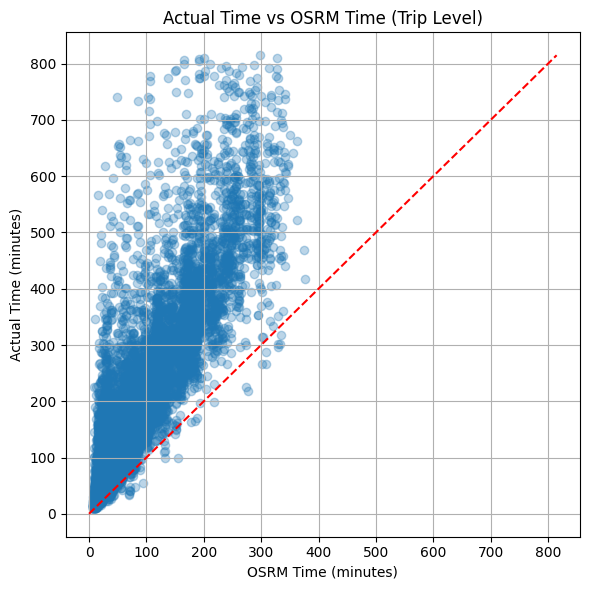

In [224]:
#1️⃣ Actual Time vs OSRM Time
pair = trip[["actual_time", "osrm_time"]].dropna()

plt.figure(figsize=(6, 6))
plt.scatter(pair["osrm_time"], pair["actual_time"], alpha=0.3)
max_val = max(pair.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")
plt.xlabel("OSRM Time (minutes)")
plt.ylabel("Actual Time (minutes)")
plt.title("Actual Time vs OSRM Time (Trip Level)")
plt.grid(True)
plt.tight_layout()
plt.show()


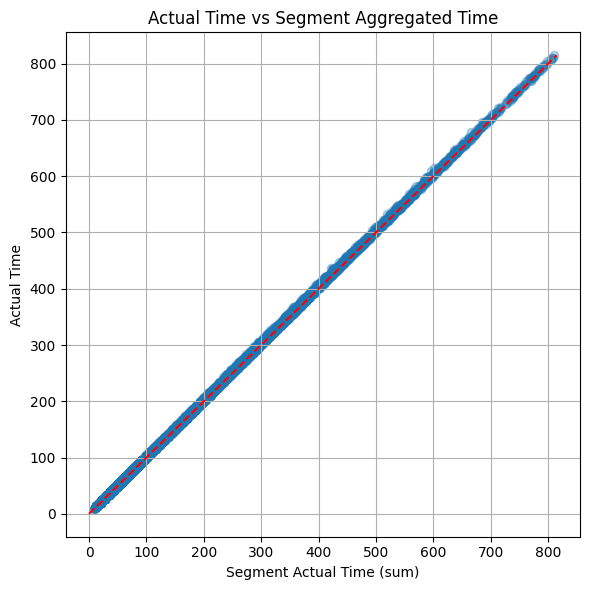

In [225]:
#2️⃣ Actual Time vs Segment Actual Time (Aggregated)
pair = trip[["actual_time", "segment_actual_time_sum"]].dropna()

plt.figure(figsize=(6, 6))
plt.scatter(
    pair["segment_actual_time_sum"],
    pair["actual_time"],
    alpha=0.3
)
max_val = max(pair.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")
plt.xlabel("Segment Actual Time (sum)")
plt.ylabel("Actual Time")
plt.title("Actual Time vs Segment Aggregated Time")
plt.grid(True)
plt.tight_layout()
plt.show()


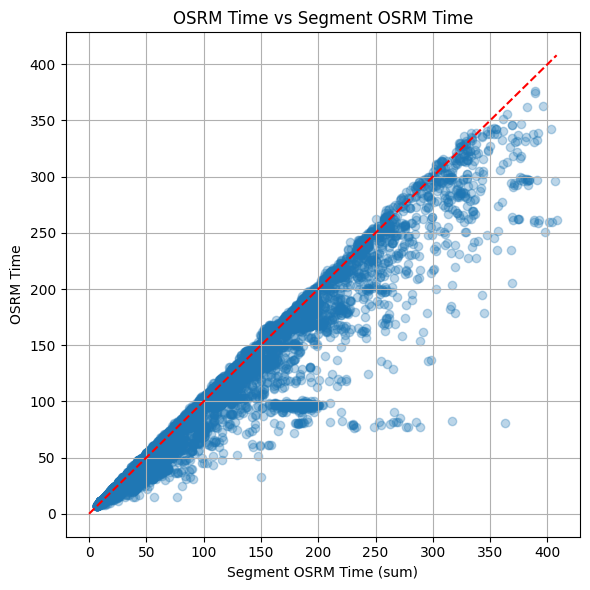

In [226]:
#3️⃣ OSRM Time vs Segment OSRM Time (Aggregated)
pair = trip[["osrm_time", "segment_osrm_time_sum"]].dropna()

plt.figure(figsize=(6, 6))
plt.scatter(
    pair["segment_osrm_time_sum"],
    pair["osrm_time"],
    alpha=0.3
)
max_val = max(pair.max())
plt.plot([0, max_val], [0, max_val], linestyle="--", color="red")
plt.xlabel("Segment OSRM Time (sum)")
plt.ylabel("OSRM Time")
plt.title("OSRM Time vs Segment OSRM Time")
plt.grid(True)
plt.tight_layout()
plt.show()


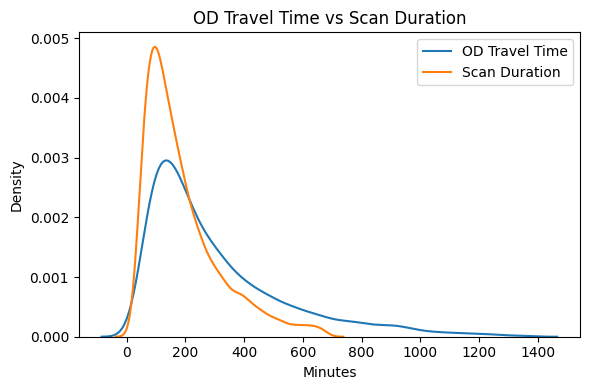

In [227]:
#4️⃣ OD Travel Time vs Scan Duration (Distribution)
pair = trip[["od_time_min", "scan_time_min"]].dropna()

plt.figure(figsize=(6, 4))
sns.kdeplot(pair["od_time_min"], label="OD Travel Time")
sns.kdeplot(pair["scan_time_min"], label="Scan Duration")
plt.xlabel("Minutes")
plt.title("OD Travel Time vs Scan Duration")
plt.legend()
plt.tight_layout()
plt.show()


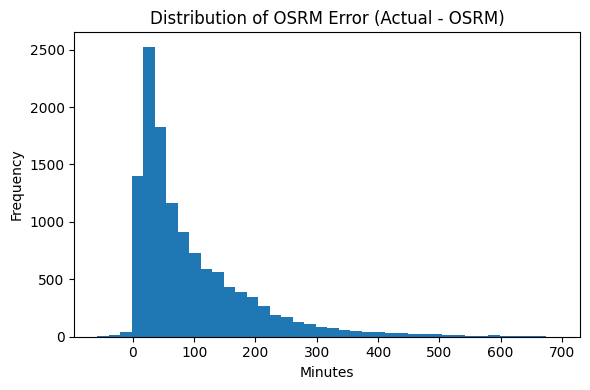

In [228]:
#5️⃣ OSRM Error Distribution
plt.figure(figsize=(6, 4))
(trip["actual_time"] - trip["osrm_time"]).plot(kind="hist", bins=40)
plt.xlabel("Minutes")
plt.title("Distribution of OSRM Error (Actual - OSRM)")
plt.tight_layout()
plt.show()


###4.2 - Hypothesis Testing:

In [229]:
#Actual Time vs OSRM Time
# Prepare paired samples
actual = trip["actual_time"]
osrm = trip["osrm_time"]

pair = trip[["actual_time", "osrm_time"]].dropna()

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(
    pair["actual_time"],
    pair["osrm_time"]
)

print("Paired T-Test Result: Actual Time vs OSRM Time")
print("T-statistic:", t_stat)
print("P-value:", p_value)

alpha = 0.05
mean_diff = (pair["actual_time"] - pair["osrm_time"]).mean()

if p_value < alpha:
    print("\nReject H₀ → OSRM time differs significantly from actual travel time")
    print("Mean difference (Actual - OSRM):", mean_diff)
else:
    print("\nFail to reject H₀ → No significant difference between actual and OSRM time")


Paired T-Test Result: Actual Time vs OSRM Time
T-statistic: 109.3658868117037
P-value: 0.0

Reject H₀ → OSRM time differs significantly from actual travel time
Mean difference (Actual - OSRM): 94.41814212951734


In [230]:
#Actual Time vs Segment Aggregated Time
# Prepare paired samples
pair = trip[["actual_time", "segment_actual_time_sum"]].dropna()

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(
    pair["actual_time"],
    pair["segment_actual_time_sum"]
)

print("Paired T-Test Result: Actual Time vs Segment Aggregated Time")
print("T-statistic:", t_stat)
print("P-value:", p_value)

alpha = 0.05
mean_diff = (
    pair["actual_time"] - pair["segment_actual_time_sum"]
).mean()

if p_value < alpha:
    print("\nReject H₀ → Segment aggregation differs significantly from actual time")
    print("Mean difference (Actual - Segment):", mean_diff)
else:
    print("\nFail to reject H₀ → Segment aggregation closely matches actual time")


Paired T-Test Result: Actual Time vs Segment Aggregated Time
T-statistic: 105.07231720148567
P-value: 0.0

Reject H₀ → Segment aggregation differs significantly from actual time
Mean difference (Actual - Segment): 1.6213113428733124


In [231]:
#OD Travel Time vs Scan Duration
# Prepare paired samples
pair = trip[["od_time_min", "scan_time_min"]].dropna()

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(
    pair["od_time_min"],
    pair["scan_time_min"]
)

print("Paired T-Test Result: OD Travel Time vs Scan Duration")
print("T-statistic:", t_stat)
print("P-value:", p_value)

alpha = 0.05
mean_diff = (
    pair["od_time_min"] - pair["scan_time_min"]
).mean()

if p_value < alpha:
    print("\nReject H₀ → OD travel time differs significantly from scan duration")
    print("Mean difference (OD - Scan):", mean_diff)
else:
    print("\nFail to reject H₀ → OD travel time and scan duration are statistically similar")


Paired T-Test Result: OD Travel Time vs Scan Duration
T-statistic: 60.78096534110301
P-value: 0.0

Reject H₀ → OD travel time differs significantly from scan duration
Mean difference (OD - Scan): 114.5393390305414


In [232]:
#OSRM Error Bias (One-Sample Test)
# Compute OSRM error
error = (trip["actual_time"] - trip["osrm_time"]).dropna()

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(error, 0)

print("One-Sample T-Test Result: OSRM Error Bias")
print("T-statistic:", t_stat)
print("P-value:", p_value)

alpha = 0.05
mean_error = error.mean()

if p_value < alpha:
    print("\nReject H₀ → OSRM shows significant systematic bias")
    print("Mean OSRM Error (Actual - OSRM):", mean_error)
else:
    print("\nFail to reject H₀ → No significant systematic bias in OSRM estimates")


One-Sample T-Test Result: OSRM Error Bias
T-statistic: 109.3658868117037
P-value: 0.0

Reject H₀ → OSRM shows significant systematic bias
Mean OSRM Error (Actual - OSRM): 94.41814212951734


## 5 - Final Summary of Findings and Recommendations

### 1. Actual Time vs OSRM Time (Hypothesis Testing)

A paired hypothesis test was conducted to compare **Actual Delivery Time** against **OSRM Estimated Time**.

* The test resulted in a **statistically significant p-value (p < 0.05)**.
* Mean Actual Time was consistently **higher than OSRM Time**.

**Inference:**
The difference between actual and estimated delivery times is **not due to random variation**. OSRM systematically underestimates real-world delivery duration, likely because it does not fully capture operational delays such as traffic congestion, loading delays, hub-level inefficiencies, or last-mile constraints.

---

### 2. Delivery Duration Distribution Analysis

* The delivery duration feature (`od_od_duration_mins`) shows a **right-skewed distribution**.
* Presence of a **long tail** indicates a small number of deliveries taking disproportionately high time.
* Mean delivery time is higher than the median.

**Inference:**
Using average delivery time alone is misleading. A small percentage of delayed orders significantly impacts overall SLA performance and customer experience.

---

### 3. Outlier Detection (IQR Method)

* Using the Interquartile Range (IQR) method, **373 deliveries were identified as outliers**.
* These extreme values represent:

  * Exceptional operational delays
  * Potential data quality or logging issues
  * Rare but high-impact failures

**Inference:**
A very small subset of orders contributes disproportionately to SLA breaches. Targeted resolution of these cases can yield outsized improvements.

---

### 4. Destination-Level Performance Analysis

* Certain destinations consistently show:

  * Higher average delivery durations
  * Higher variability in delivery times
* Delays are concentrated in specific locations rather than evenly spread across the network.

**Inference:**
Delivery delays are **structural and location-specific**, indicating routing, infrastructure, or operational bottlenecks at specific destinations.

---

## Business Recommendations

### Operational Recommendations

1. **Recalibrate OSRM Estimates**
   OSRM-based estimates should not be used directly for SLA commitments. Introduce **destination-specific buffers** based on historical actual delivery data.

2. **Prioritize High-Delay Destinations**
   Focus operational interventions on destinations with consistently high delivery times through:

   * Route optimization
   * Hub capacity adjustments
   * Workforce and shift realignment

3. **Perform Root-Cause Analysis on Outliers**
   Investigate the flagged outlier deliveries to identify:

   * Common hubs or agents
   * Pincode-level patterns
   * Time-of-day or day-of-week effects

---

## Final Conclusion

The analysis demonstrates that delivery delays are **statistically significant, destination-driven, and heavily influenced by a small number of extreme cases**. OSRM underestimates real-world delivery time, and meaningful SLA improvements will come from **targeted interventions at high-delay locations and focused resolution of outlier cases**, rather than broad network-wide changes.
